# The following file is a combination of all the simulation jupyter notebooks
## The file contains four simulations
<br> 1) A drone stabilizing itself under wind dusturbances at the origin
<br> 2) A drone stabilizing itself while following a circular trajectory under wind dusturbances
<br> 3) A drone finding the optimal path to reach a vertical orientation
<br> 4) A drone finding the optimal path to do a full flip

<br> To get a better understanding of the equations, controllers and the cost functions, please refer to the [report](https://github.com/ar6841/Quadcopter_optimal_control_using_iLQR/blob/main/Drone_controller/Report.pdf)

In [1]:
# Load the required libraries
import numpy as np
import quadrotor
import matplotlib.pyplot as plt


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAWpJtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA3OZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQArISJA0agX3rQrxAFVDm
jgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzzgStuUpMltOrgd3xiXeRy
NijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6aV0xf5e1Y3eMSRhlnOEg
5t6laqwn4ehgEZ2RN/0//u4oRdcLYjvj7rDRnH5cb7OVciDfMNCehaTP+JN35QogZV2reo0GdqlP
bIKdk6lNM4zUT3GEO0Jj0AZ8uQG2SGD05XbPtMrJ8kk6HuBdu2H6+CdKkO7pz/etCbQB3sYu0DBX
ccEzOQXnIBONgAEul9kOJIUAqQGsQCj51cSf/x6vBzdZNXNy56tMYhq4rWxtpEMAB81lipI1UTt6
D2ppE+W9GmTFQ/XyGuiErj2kB7sjxeQHOZirU79ewOHrOQZRzvUt+8gs6Cp2DztAxQOBonsAuH6s
e3FNYcztZ3fd85Oje+zL0lL6B7yoyEB14cZg11u8rt6Sf+by7HawlpoCSn02F/47SRuxxi0n3Hiq
OPv+W4TYkvF0cFEubbJcfsX+VBIixJ3y64qWX/a5MLrfmwIR5XLflGl0aTbdW8EkhE8TyYnh39Yn
/9jd13mk4BDOryI339VcEzGtzxYrKMmHe2H+bxN+X0rC8MIqS5RYbwbdvZ32aDE6+x+PJttvlgoU
4SFF93Smr6SM0PB9uL585A5+AnW4MgTmdv57rJIGMdyjSAjyMVkcZXWHufL6PZHpume+zeYxIAAA
CfBzAF8okJhgyAarauQ/h66iTGUoLxrGklkTN4qNuIIM+CmqMQNmKnnW18x2GT1z2/HLRtn+BqH/
COr48wvUmQWf+XpyTFxfma/S8zYm00FYz9L2ErRiyvTG0E3z1BM6v+g47vw46TPiHHy1/3217JAg
7+M1JlG9f6QdXtR6MgJJp9cBgsIJ5EjXrlaiInWHVAobnb2lTco2n3yxqlYeoFqTiYMrDcdL7HMM
Y9UlUbZJvB32ZyJN9hqCVH67fwWXaB5U2QQjHvCgjBWmbeSi0zAxNogcO8a02VZAhkLyZDD50X/j
yLv9Agb89/W5dn9b2VbHKwoW2kdTdOYIT/snuRlR7Fblw2t/cBYjoK9ppTZqGXL5VkDGh1soMCO9
vZAAVb5qTwH4Qcp+Sx+dDADUDX1Q5zqGHvfRSPMMfZF6EUYs20MF3Y4T4VLEFzCFT8nmrOnLHiLd
slIHAMsHYw8hES4f/62tQ+VIlhYjdFdCKIpZna4yJQH/D+HrF2imzp19Nya+L0G1GATDMo55Jkyp
xjtXAEmrSu9MYATJFck85cDvq+hdzseo5IQZPYi9P99jxdnbYcUTbxPzoRF8ZhCzVAEZZYSdPHhC
v8V8ZGX99Sr5ZyuAWHpH/H8eGZMmLba6foDO73eD7E/+ACYpFECjSyfycWhzF5d1ZjmstcmMmSpM
23pMDa7W/Bey62SSqXSgl1auVbGHXvLnDken/dN+V2r3HYCgvnnDQKobVKNKUoPKMfTdUt71TOFu
SzMAAAMAAAMArFjsZhNY27UfZ2fC0Oh2/4vvomwjhEQYbxZw0httslcqBNa1ZitPwAVJby1PZBeU
5e39jiVJTFZa8I6RtY5XDNcu1h7TnnwywqNdB0oZR+MUNKrgeSkm6xajYM0ZaH938ctFyHhQe8H2
geB1nsG2OBUy45t4S3J0Rfl2b72Z6IdgdKEJ6f7XmQexGxw5uHvnz/RgyrGLBaJcGM/RgW6CX78Q
X//6EzijHbwg/IPlNIbgFFVlBgkVfkFq0LDZD8NDjGq9ogibafq++R8PRHKgDmD6qnt8UtZ1AWjy
8/9/heL3OgaJ1uSROMibOeL9dtjp87Ei8J4GSsb0FqZur70SZzL9x5GYKAARqjImI3LpFD+8C8NQ
6FeygqNTbCQwRMh4JxqF0+/bt82ihKKsYhL9gvEGVL3l4ewx+Ia+6AMSAC8LMfs98duxfGyFlNSO
iTJbmEGFXF1t//az2bHX3IlToLr0uuDEgNRHVV3IaLAFa1CEkeotLS+iK7TK82mejfng6rHVJ0sg
TDaWO3F6abgQWhHd+6DbfHA76MsES4GBnBl6pO/y4HKmITy9kjVTyHKn7Vxpcv79cmsNq5AinH/r
7TIXh5WixT4VSwD2UAAAAwCKAAAu8KrP9MDcN7onZ0BserLHGJim5f5QJSOGIYdO6TCqYcEaouPe
rw/xPvZRqI9U/uGomvJgnZccZJ95ww0nvBsK9rp3fgunfm0kJOUBlfdbg0yRql6B8QYQBtdtYVyh
VHRR/eohi10i65mm7o6DLcdYAkVvRFtBb0pZY2k4yf0Xk0jTkbGDyWsptyQuDjdTMhLLRa/vN/Mc
C7kzAsmWTXI9vb7H0kUZtYq+HI5IBLZLo4FSLmj4vPooOiQmZuHUY/OiPybAjtl/MgqZLJBj0sio
h6vwxBqediUXIqY1Zb/+gHtpwHpa8AyBea0y+ZrWlH/gjtf4LVQi3m/gg94vWu0XhYSVD347d+di
jgAAAwBugAAWqWlZ0fHQ5wiqnILPPeo+F9vWX+yHMPt+jbJpLA24Y7r4RLqUU48wzbwFqf/LkiPQ
ImsXjUJUWKGbaTAcKq093lXm/lUG1PrMiAVkyg+EFcB5gbly1Xxoz3DSZU0iSQf3Ww3m5ChAAAXm
cchwZJTMC5h47ZulWiZYHWtW9zG9kPj7F+Lzg1++WSOtYp68FAuLgqPjZCympHQxu7Si0VjXYSUs
TLnro2zIeHnDsB8LI+j35E8aYh33SVb3wzujkJo1QcDv18s2kbr8+iwz3wa2pGoq/wxx6nO1oxLY
s2C1i0UXxz3W5i/HN8N9/

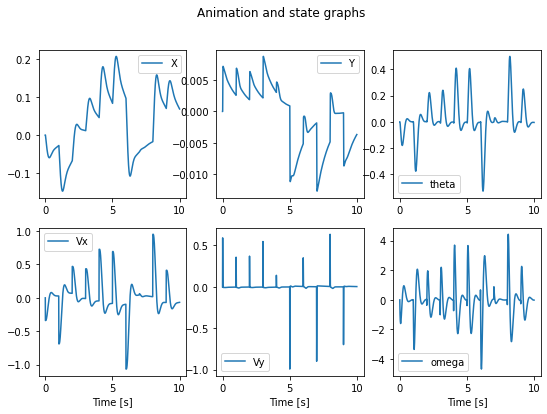

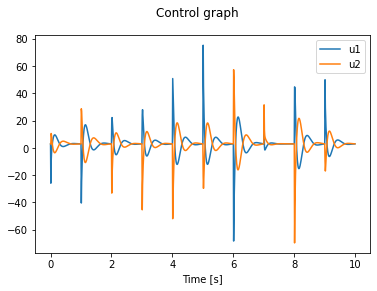

In [2]:
# Drone stabilizing itself under wind disturbance

# Function to linearize the dynamics of the drone.
def get_linearlization(z,u):
    A = np.array([[1,quadrotor.DELTA_T,0,0,0,0],[0,1,0,0,-quadrotor.DELTA_T*(u[0]+u[1])*np.cos(z[4])/quadrotor.MASS,0],[0,0,1,quadrotor.DELTA_T,0,0],[0,0,0,1,-quadrotor.DELTA_T*(u[0]+u[1])*np.sin(z[4])/quadrotor.MASS,0],[0,0,0,0,1,quadrotor.DELTA_T],[0,0,0,0,0,1]])
    B = np.array([[0,0],[-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS,-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS,quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA,-quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA]])
    return A,B

# Linear Quadratic Regulator
def stable_LQR_controller(state,i):
    # Set origin points
    z_origin = np.zeros([quadrotor.NUMBER_STATES])
    u_rest = np.array([quadrotor.MASS*quadrotor.GRAVITY/2, quadrotor.MASS*quadrotor.GRAVITY/2])
 
    A,B = get_linearlization(z_origin,u_rest)
    
    # Cost matrix for state
    multi = 600
    Q = multi*np.identity(quadrotor.NUMBER_STATES)
    Q[1,1]=multi
    Q[3,3]=multi
    Q[4,4]=1
    Q[5,5]=1
    
    # Control cost matrix
    R = 0.1*np.identity(quadrotor.NUMBER_CONTROLS)
    
    P_prev = Q 
    
    #solve Riccati recursion
    for i in range(1000):
        
        Kn = -np.linalg.inv(B.transpose()@P_prev@B+R)@B.transpose()@P_prev@A
        
        Pn = Q+A.transpose()@P_prev@A + A.transpose()@P_prev@B@Kn  
        
        P_prev = Pn
        
        K = Kn
    
    
    u_stabilize = K@(state-z_origin)

    u_original = u_stabilize + u_rest
    
    return u_original

# Plot the resuts
horizon_length = 1000
z0 = np.zeros([quadrotor.NUMBER_STATES,])

# Set disturbance = False for NO wind
t, state, u = quadrotor.simulate(z0, stable_LQR_controller, horizon_length, disturbance = True)
# we can plot the results
plt.figure(figsize=[9,6])
plt.suptitle("Animation and state graphs")

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.suptitle("Control graph")
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# Animate the results
quadrotor.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABYhJtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA3VZYiEABD//veBvzLL
XyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuH+4x2xPbAAAArgAVwJEflNQL71nT4ADkMV
VPbRK84RdyqRUb6gRRR3eFQvVE+KTOH603JMImy4IeauYGfkC5QJLIc84ErblKTJbTqwzR4Yl3kc
jYnKfKjcI37bKL3OEZMXCcYw2mayGHGQhOtp/ofbg//2++sGGRgJage3e3p1cJ4vwELvqcBAznSW
jm9uE69bPcEEqxzH/ygnG5ls/l7oCONpPHi5MF+afCNoWeP58/Z8RsObgDj//zh/iGvAvxfuZqjc
U5W5o6Tq1gjm3t/pYq0u4PadNQuObUuW0OBMT7N83rYAgHNJxa3N2McX3eP0RxBpxxpjJUjfD9Sx
ZtvsMU/3NYLyXWwdxPxsE8m/etAoXWBKOqO9aFAABgatSb7uaxP9AouKcJ/qFOvwIjh5t+3Ikc7V
hQAjzRmZMHot5lMFczDzSdu5sdkJNYf/vfQjt93X8zvGgO9oNVTOKjQtTm1CZRzvUt+8hHC7EXTV
yYv076PieFfPo2/wpFNJwCxgp9AbPY7s8Wh9Ngb4C7tP4uNXU5O88hjnBTu2tIGl0raDGlPKPlZQ
7DriLXvFLoTQDff+nRG69C65QwSGTXHopDmBf7GS1UUSFZ7rpIWhYVwe35uu4n5G+Rp4nAOlFPyx
5bYx4rRhyPHF7VIWoxIbur4j7CXugwbHtD+7KS7v64zm3DBS3wFcxdHkXpOQsCA2z4+fuSu/fey9
05DmIrkashSmy0pmxUvh6f/al8+cVV0HzygDPOH+3C8Ggk3GJYoowXpxRvZKfOXxKNsAAAMAAC0t
a6Js3HXOAegVFUju12uamM9wD4O4315gdc/r0EGfBTVNK5O45Ra6nIZNf1znZ1/o2z/A1D/hSr6o
vYfNO5B5LgHGGbVYyXuZzjTU0FZFGc/7us0qr2NLGJN7rzh9XbVyd34cdJ0DWQPF/XBt1a01JD05
69TMf/qBgWwXg5I1RaJRjxlmYodaOSQRFo3CTVVjRx4zs3x4GeDWw28inBV94QcOHYDCrN3A1+DC
39uf1EsnWTiOC/mRuKzmHyoim9BToWkBl3NUaPru6NF/Yz5utr0jLnnD8mQ3xh5f+lfXgP6yWch2
s5KpGWpbKREA0Z9l37QNWiju65bUBmK/AWq6Ax/+ogO1YcFHswmKAEYDck1gABJ1Q6ygsPOhnNNS
SwOqm6YpDHTa42BycN45VZHeyWSJrbR2URi6skxJQvijfAXLv9Hd1gF4I3Mxh4vRfR/+9k5rH3vQ
wQQbU/i+4W49xKFoB8fsFXxBh5MIi06Gyv0RfSwPseCKbP3Ggw8WOjE4c5icYmfSRJs9QCZnez6J
vkPQUWO0bTcQjshn/nxBvrS5DSg0F3ydB+4dnSBufDeCMp7111CYjgFBIKT/I3gAiRaxE5/sFog3
VrKgzDRQKOrjoMZiVv2GkmsOAv8C5u58cI6F/m+ye0UTtyKjVYo6TWlFLVs/cT4LzLdhO7zBVWFP
gTmjWaHo6VZxnKKq1gsnlxsYSSH8MRnkk+WxyNP10UL0GVyXE9cXnFbmH7Lzcj6dAJ3P+aiMrF6T
9KtOWa+vn/napkAASMXigAFiIyuCDc7Bll9sw7YenXK0pllj40sPqVpt+/ME8d1HFJBD7JIse5Nn
PdR+KveXfBIrK/IfkkSOcstE2psr+vyKw0xcojrwIIwfQzgdrd/ZKSRnVPC23GX5B3/tpy5UBpd2
zlgNlHvWdNkDDgKthhu9sASZ0JDjsgxs6uK4e0asXN9L0cYc0DBaCQkuLbAYPfzxjliMaiC41thy
f7RCOvmUMG4EsrZHTF1Tk53kHUj50tTQ6TyFeLiSV4RY53k9C1mcc0Sy3kkCFOB8T1QByBkZKisV
uQSEUKo3MW9L2xXQbM8lSe86ehREmv8e6qCeA/YCVTRMlJ46u0oIE0Hi6NAQQuArKP4geZnSqydX
LX8Y8KbdpOfhEKOHks78lXLZOXIdCuxWSvGbFcunauiF6n+aHvat63a10q0R0lntRZccJrYuCSix
hbkD9XMjYKrg7kxU61p+qBvIZyOg37jsIfBuGQMk7KPoUGVJGR68HgbX2i3KOzYCVcY26PQfNaV6
nwfHpBShsXuvcTiTrLIME8jITOd2JcuViW6e6glL/l7ccVAi46hGW2+JUK/HSdBjiZzMtGJslSdy
TWNDFkhabk6vM9YhrQW/7kmWzyAAUdaFy7Ukfs28zddAAADNFs73/068Q+FryFeF8sscYmKHV/lh
vqLe/BjWxzlAHaJ1Rce9Xh/ifeyVYJltJ2P+bawxdbze3E3W2CsdSSwzRgPMXM003sJAum7FtK3C
vXIcBpvtenXKrR4iGyZor1XNcF1zhLI6sPfz/gaI7W1I3aAxxUniGpycrW1bw/DGs6ciGNM//pW9
Y5gcYThLgLmV/XC1QPX/ZarNbP+0ZyqGTo8nj8mOHl3dEkneoZqCPzS6AtCalpys1znxg0ksz9RZ
4E5wl5G7Mbjed2aPxtMWknRvP52LTbPne6/DyTRSqknAwRuM4gnGXFRDTgPF3xp/RfyRFhsCVYXR
V/KAxjlN+CGsuAAAAwAAAwBbuLeQd5VKzI6euK7kpxdYE/zZ/UjFS8fq01N4knhmMo0twlMDh4fN
u4Y7b6k9L0BYMa00NGIChWYDsOo9aReRO4vqM3szwzEy07P2Pc5XDeYG5cpCmaM9w0mVNIljhyky
uWfbgABrHQGpnBCjlU03+2bpVomvUGhjczm28R8fYvxedV/vJUTsBgDiOLrAJTFR8bIWU1I6LWdY
N8tt5B+s+S+9CeCvdaSMwdgPi8Ynhwv8m1GgK1/ib4Z3Ru341nihde+WbSN1+4HQkwG3EdW5RTv8
McjJUFtqPCYPa4nlgUIl3

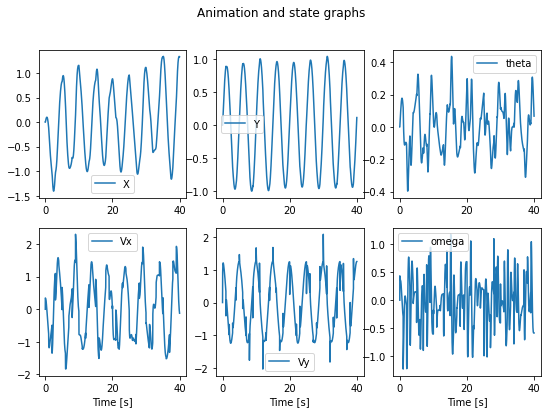

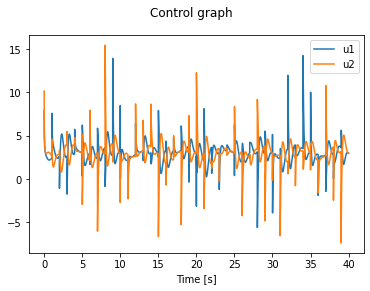

In [3]:
# Drone following a circular trajectory under wind disturbance

# Function to linearize the dynamics of the drone.
def get_linearlization(z,u):
    A = np.array([[1,quadrotor.DELTA_T,0,0,0,0],[0,1,0,0,-quadrotor.DELTA_T*(u[0]+u[1])*np.cos(z[4])/quadrotor.MASS,0],[0,0,1,quadrotor.DELTA_T,0,0],[0,0,0,1,-quadrotor.DELTA_T*(u[0]+u[1])*np.sin(z[4])/quadrotor.MASS,0],[0,0,0,0,1,quadrotor.DELTA_T],[0,0,0,0,0,1]])
    B = np.array([[0,0],[-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS,-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS,quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA,-quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA]])
    return A,B

cos=np.cos
sin=np.sin

#Function to generate the trajectory points along the circle of radius 1 (z*,u*)
def generate_trajectory_points(TRAJ_TIME):
    t = np.arange(0.,(TRAJ_TIME+quadrotor.DELTA_T), quadrotor.DELTA_T)
    phi = 2*np.pi*t/TRAJ_TIME
    
    z_traj = np.stack((np.array(cos(phi)),np.array(-sin(phi)*2*np.pi/TRAJ_TIME),np.array(sin(phi)),np.array(cos(phi)*2*np.pi/TRAJ_TIME),np.repeat(0,t.size),np.repeat(0,t.size)))
    u_traj = np.stack((np.array(quadrotor.MASS*(quadrotor.GRAVITY-(sin(phi)*4*(np.pi**2)/(TRAJ_TIME**2)))/2),np.array(quadrotor.MASS*(quadrotor.GRAVITY-(sin(phi)*4*(np.pi**2)/(TRAJ_TIME**2)))/2)))
    return z_traj, u_traj

#Function to solve LQR which follows a trajectory    
def solve_LQR_trajectory(Q, R, z_traj, u_traj, N):
    '''
    A, B, Q and R are the matrices defining the OC problem
    z_traj is the trajectory of desired states of size dim(x) x (N+1)
    N is the horizon length
    
    The function returns 1) a list of gains of length N and 2) a list of feedforward controls of length N
    '''
    
    
    n=N-1
    K_gains = []
    k_feedforward = []
    P_prev=Q
    p_prev=-Q@z_traj[:,N]
    
    while(n>=0):
        
        A,B = get_linearlization(z_traj[:,n],u_traj[:,n])
        
        Kn = -np.linalg.inv(B.transpose()@P_prev@B+R)@B.transpose()@P_prev@A
        
        Pn = Q+A.transpose()@P_prev@A + A.transpose()@P_prev@B@Kn
        
        kn = -np.linalg.inv(B.transpose()@P_prev@B+R)@B.transpose()@p_prev
        
        qn = -Q@z_traj[:,n]
        
        pn = qn+A.transpose()@p_prev + A.transpose()@P_prev@B@kn
        
        K_gains.append(Kn)
        k_feedforward.append(kn)
        
        P_prev = Pn
        p_prev = pn
        
        n=n-1
        
    
    K_gains.reverse()
    k_feedforward.reverse()
    return K_gains, k_feedforward
    
# Controller
def circular_trajectory_LQR_controller(state,i):
    j=i
    
    if(i>=N):
        while(j-N>=0):
            j = j-N
            
    u_real = K_gains[j]@(state) + k_feedforward[j] + u_traj[:,j]

    return u_real
    
    
    

#Set time to finish circle
circle_time = 5

#generate trajectory points
z_traj,u_traj = generate_trajectory_points(circle_time)

#number of points
N = int(circle_time/quadrotor.DELTA_T)
multi = 500 #multiplier for cost

#Define state and control costs
Q = multi*np.identity(quadrotor.NUMBER_STATES)
Q[1,1]=multi
Q[3,3]=multi
Q[4,4]=1
Q[5,5]=1

R = 10*np.identity(quadrotor.NUMBER_CONTROLS)

K_gains, k_feedforward = solve_LQR_trajectory(Q,R,z_traj,u_traj,N) #Set K_gains and k_feedforward as global variables


horizon_length = 4000
z0 = np.zeros([quadrotor.NUMBER_STATES,])
z1 = np.zeros([quadrotor.NUMBER_STATES,])

#Set disturbance = False for NO wind
t, state_list, u = quadrotor.simulate(z0, circular_trajectory_LQR_controller, horizon_length, disturbance = True)

# we can plot the results
plt.figure(figsize=[9,6])
plt.suptitle("Animation and state graphs")

plt.subplot(2,3,1)
plt.plot(t, state_list[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_list[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_list[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_list[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_list[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_list[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.suptitle("Control graph")
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

#Animate the results
quadrotor.animate_robot(state_list, u)


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAVattZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA2uZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQArISJA0agX3rQrxAFVDm
jgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzzgStuUpMltOrgd3xiXeRy
NijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6aV0xf5e1Y3eMSRhlnOEg
5t6laqwn4ehgEZ2RN/0//u4oRdcLYjvj7rDRnH5cb7OVcVeDDGblDP4oiq80WQOVQ/kvRcX6GntS
Tyf2SkA1tyCNIyktbublNs2xhPCwz3kf2rP4S8jvTxqEdS7q8r7UnnwkyNZtsidmfggEoAALuDpT
UqgO2Nyc/nyo2P8mgMLl9W2v4DablAAh40KXLQOiQA0eTXhSNU48dP9tF0wwuFwd4UGlWZaNRk+c
PEQ/GeZ0B3tBqqih8K40vtZGgyZSX/Cllsgqdg87QMUDgaJ7ASAyDb/CkU0nALDfO+cnRvfZl6Sl
9fLa1LK9B3Q1wTbHr5w1s3/m8ux2rJaVHDZCUV/y38xSEO80k+48n4ueT6r6VDh4ujgolzbZLj9d
/49jd6q5J0Apc+ZVVkguqgptHCHct+UaXRpPEHEQSQlTAE+C6VUm1cCu4Xv2VqNhLgJbIEN0ANjG
Wy8MVq3JKMY05hpbR64iE/eKC9o4qlYJ5IPqKNdXjh1djG4LNrYxnnanJ8qnXDyjMpvpBy09k+gP
+yMdyjSAjyMVkcZXWHuMKcLrx2zJKo0vJ/oAAAMAqAaU9touYtN2AXUJSoJdSpHArEcVC749O5Sb
2hP9XLdLOhAU8MxPlFrqchk1/bzt+OWjbP8DUP+FdW7r1TiNHUHkuAcYYV+Zr9LzNibTQVj0cmkt
RAijy+vzHaNKiM8D+nJ3fhx0orGBGXhtICKlMpj0569SMT/6QYJoJ7/xtTcttFvjmflIUOtHGJdS
etk5uIQtaJwRwcMcX0OO6b/SXqJhncjRbSP1GER24YFKEJGaOnc/q1LrTv5m2Kvr4Cs2DNiAZMTC
fKwpNogcMkFT4BUVH9N7EM/xQxf/ei8FycjOksOGC7P63sq2OVhQtvfRfJWK8HA0XS8bVdxNzjb1
OgGgEVKO0GnnRJKKahPv6SFlwBYTpYADak7hcBZgtWs3/3OhF+NWRY6JOE1gf5IdQKhE4aij2J6/
vMF3Y4T4VbCxjbFDHHE7yfj8wt7ZKQOAZYOxh5Gmqn//crRr4p4DFGb+udQ7lWGjbglI/7P8sze8
GrmOJXNh2vK0DvfS1EATDMhBt6FGxwjGhLQ0rCGYeU2WMofxZLpiaigboKLHaNpuIR2zr/58gb7U
IvG0rEZ5VI+dD7kPuhGch+paVGtEktNRc+pM9/oGduN9QQZzXFNfqWlRrRBkEBTSSITkXS1Ds/8M
Xl3VmOay10svjSAqVjfUfu/Zv3sutkkql6zfsu02zUzr4rw07doGaZ8kjcsxsNWj+kZo9UOQvdk/
pqayyjx7jMQWT+1q5TX4vQAAAwAADfIyrq8FguFlpKxohclG7BIOoClRCURBhvFnDSG22yVRzboy
fTyxNFNc85v6VJ6uEMJyMx/8G8RZedHRITQl9EvlAJOgsmentWlky9rLIGjCINNxbYIP7a3UO/HU
kIKqh1j5ajfD2uRonRB7wfaB3NH5kbsyDBFLo7HtE0pRET3hYp34f/9cFr1Mdv893tkA+TIje4BS
BYxSLBaJcHP6FJuhuZuQNKQ4T/qR58FZFovKZO6MBuu4GXoPvN05uu+HgnxY6RT7Uv/YoIuzWrJr
A/XHwO7ktfvJtTgoyxRVs3CKWdD5E6rQoRlM7KkDtgQT92STIOjlr3XCaE2l0kqZ9jx5NyumU2fu
WyV48eYTmGCkK2ifBodBIMWwmjWMDg845bJ9TNnIrthIYS9MR2W1ZuzRvFySZ9Xywx2OAeHMycY3
j7F+L0LL/nnYef8pE5dlfCtckDtfoSGcjomMGro3il/zTZJ3gEleSTVhJ0S77e1v7l/CAA1ZBZ7Q
w+d79XxaOLek781awX6kr/sGtHqpkmoCLTZya2LEpTIwtHC4TsaENl3KLGuYVGzgy9UoCzo7r3Lp
6tBzVriHZ54b+F99bAjAjUssHdwthKgABePj0+uvn9FcMAAAGFz4E3QEGOAc3If1BiyBfMoJvg//
aAlI4Zc36OqDQi3oJZ657thV8/EeV1ECGn9w1E15ME7LqiuOZB7cpNi7Cva6d34LqN9akhJzHtdZ
1anw2g1O6RLLTrR4iGyZor1XKH71EMWukXXM04XM1IKo+aQ6n3a3avpF5srkNk1HeH4Y1nTkQxpS
rEETU/9ozZPzqu3sNL9Kv8hH1hSYE6bWqglWsmOHl3dEknesb4q31O8LH1zloK5z4wDGVNuN0yZu
0HyqRjQrQf4ChQ6gVEdCzvNreah0OgTE4I2Hy0oGXRTdQv2w2YZJ5t+brX3GR7svucCNmJsYDw0G
Z9uPfVlHI+Wi9+puKqW7dfqQ1idxMj7h+VOAAAADAADJm4PE7dAE4KMYdxFBEy2kKrNm/9ofz7Jh
43OIhdrdXReO8jKmH5JQ30Xm9/8U4+OA8vycHmnKxQzbSYDhVW4uRHNs8O7drQtKfGv+N9hBXAeY
G5dCeiKrmzahwg6Fej0mtjv92lDgQSCUjF6bTRnzRreO4dFe8aky1bPTKyGGXXwLRmzRuPL/FsiM
LMnMZa/DfHn13xZRbZIsdovhsLiRFW8YkONDJGNKfs0BQRnR/2Y0NNcH+vSLEBvKfhPw9wLCGxZo
6bZ/NCsU+F6WMVR9rxKk/sKmYJa8Kil+T6fxWhKw3RA7BtjIOwoeJ9GErQAAAwAXwCMFqu1nFVWp
M6XbtwBmpwuEKGV/yyEiO

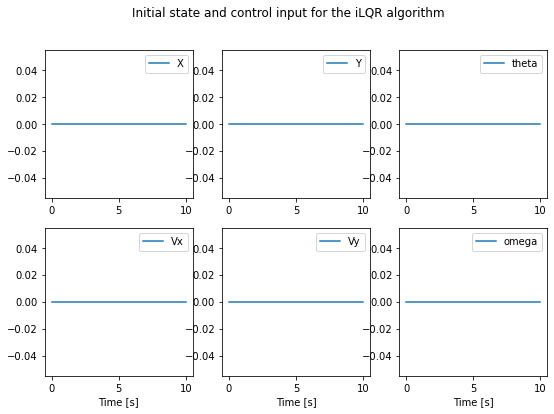

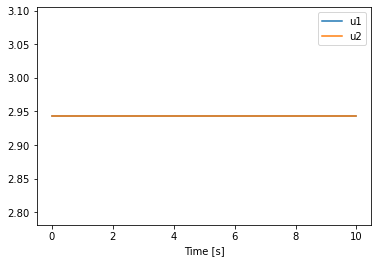

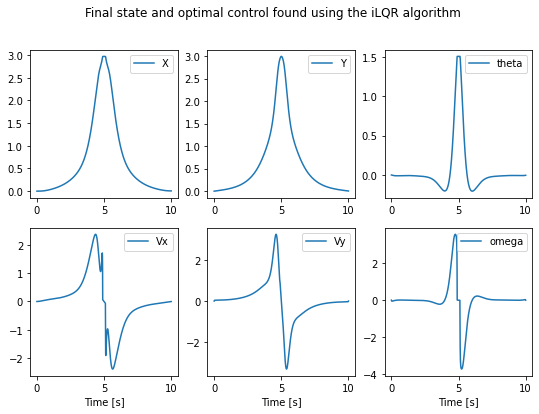

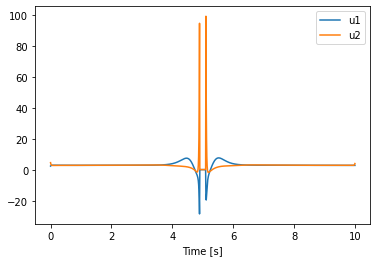

In [4]:
# Drone reaching a vertical orientation

# Function to linearize the dynamics of the drone.
def get_linearlization(z,u):
    A = np.array([[1,quadrotor.DELTA_T,0,0,0,0],[0,1,0,0,-quadrotor.DELTA_T*(u[0]+u[1])*np.cos(z[4])/quadrotor.MASS,0],[0,0,1,quadrotor.DELTA_T,0,0],[0,0,0,1,-quadrotor.DELTA_T*(u[0]+u[1])*np.sin(z[4])/quadrotor.MASS,0],[0,0,0,0,1,quadrotor.DELTA_T],[0,0,0,0,0,1]])
    B = np.array([[0,0],[-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS,-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS,quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA,-quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA]])
    return A,B

# Function which creates state and control costs to promote vertical orientation at t=5
def cost_function(horizon_length):
    list_of_Q = []
    list_of_R = []
    
    z_target = np.array((3,0,3,0,np.pi/2,0)) 
    t_lower_target = 0.49
    t_upper_target = 0.51
    
    Q_tune = 10
    R_tune = 0.1
    
    Q_temp = np.identity(quadrotor.NUMBER_STATES)
    Q_stable = 100*Q_temp
    Q_vertical = 100000*Q_temp
    Q_end = 100000*Q_temp
    
    R_temp = R_tune*np.identity(quadrotor.NUMBER_CONTROLS)
    
    for i in range(horizon_length):
        
        if ((i>=t_lower_target*horizon_length) and(i<=t_upper_target*horizon_length)):
            Q_now = Q_vertical
        
        else:
            Q_now = Q_stable
               
        list_of_Q.append(Q_now)
        list_of_R.append(R_temp)
    
    list_of_Q.append(Q_end)
    return list_of_Q,list_of_R,z_target,t_lower_target,t_upper_target


# Function to compute total cost of current trajectory
def compute_cost(z,u,horizon_length):
    total_cost = 0.

    Qn,Rn, z_target, t_lower_target, t_upper_target = cost_function(horizon_length)
    QN = Qn[horizon_length]
    
    for n in range(horizon_length): 
        if ((n>=t_lower_target*horizon_length) and (n<=t_upper_target*horizon_length)):
            
            total_cost = total_cost + np.transpose(z[:,n]-z_target)@Qn[n]@(z[:,n]-z_target) + np.transpose(u[:,n])@Rn[n]@(u[:,n])

        else:
            total_cost = total_cost + np.transpose(z[:,n])@Qn[n]@(z[:,n]) + np.transpose(u[:,n])@Rn[n]@(u[:,n])
        
    #print("total cost = ",total_cost[0])    
    total_cost = total_cost + np.transpose(z[:,horizon_length])@QN@(z[:,horizon_length])
                                                                                  
    #print("total cost = ",total_cost)
    return total_cost

#Function to return hessian and gradients of cost (Quadratic approximation of the cost)
def get_quadratic_approximation_cost(z, u, horizon_length):
    
    Qn_orig, Rn_orig, z_target, t_lower_target, t_upper_target = cost_function(horizon_length)
    
    QN_orig = Qn_orig[horizon_length]
    
    qN = 2*QN_orig@(z[:,horizon_length])
    QN = 2*QN_orig
    
    Qn = []
    Rn = []
    qn = []
    rn = []
    for j in range(horizon_length):
        if((j>=t_lower_target*horizon_length) and (j<=t_upper_target*horizon_length)):
            Qn.append(2*Qn_orig[j])
            Rn.append(2*Rn_orig[j])

            qn.append(2*Qn_orig[j]@(z[:,j]-z_target))
            rn.append(2*Rn_orig[j]@(u[:,j]))
        else:
            Qn.append(2*Qn_orig[j])
            Rn.append(2*Rn_orig[j])
            qn.append(2*Qn_orig[j]@z[:,j])
            rn.append(2*Rn_orig[j]@(u[:,j]))
    
    Qn.append(QN)
    qn.append(qN)
    return Qn,Rn,qn,rn

# Solve LQR equations for current trajectory
def solve_Riccati_recursion(Q, R,q,r,z_traj, u_traj, N):

    
    k=N-1
    K_gains = []
    k_feedforward = []
    
    P_prev=Q[N]
    p_prev=q[N]
    
    while(k>=0):
        
        A,B = get_linearlization(z_traj[:,k],u_traj[:,k])
        
        Kn = -np.linalg.inv(B.transpose()@P_prev@B+R[k])@B.transpose()@P_prev@A
        
        Pn = Q[k]+A.transpose()@P_prev@A + A.transpose()@P_prev@B@Kn
        
        kn = -np.linalg.inv(B.transpose()@P_prev@B+R[k])@(B.transpose()@p_prev+r[k])
        
        pn = q[k]+A.transpose()@p_prev + A.transpose()@P_prev@B@kn
        
        K_gains.append(Kn)
        k_feedforward.append(kn)
        
        P_prev = Pn
        p_prev = pn
        
        k=k-1
        
    
    K_gains.reverse()
    k_feedforward.reverse()
    
    return K_gains, k_feedforward

def integrate_dynamics(z0,u_guess,horizon_length):
    
    z_guess=np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
    z_guess[:,0] = z0
    for i1 in range(horizon_length):
        z_guess[:,i1+1] = quadrotor.get_next_state(z_guess[:,i1], u_guess[:,i1])
    return z_guess

# Integrate dynamics
def forward_dynamics(z0,K_g,k_g,horizon_length,alpha):
    
    z=np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
    z[:,0] = z0
    for i2 in range(horizon_length):
        u[:,i2] = u[:,i2] + K_gains_curr[i2]@(z_curr[:,i2]-z_guess[:,i2])+k_feedforward_curr[i2]
        z[:,i2+1] = quadrotor.get_next_state(z[:,i2], u[:,i2])
    return z_guess, u_guess

# iLQR algorithm implementation
def solve_iLQR(threshold = 0.000001):
    
    
    #initial guess
    
    T = 10 #seconds
    horizon_length = int(T/quadrotor.DELTA_T)
    
    # Initial guess u =mg/2
    u_guess = np.stack((np.repeat([quadrotor.MASS*quadrotor.GRAVITY/2],horizon_length),np.repeat([quadrotor.MASS*quadrotor.GRAVITY/2],horizon_length)))

    #integrate the system to find z_guess
    z0 = np.zeros([quadrotor.NUMBER_STATES])
    
    z_guess = integrate_dynamics(z0,u_guess,horizon_length)
    
    # Save initial guess
    u_initial = u_guess
    z_initial = z_guess
    
    # Initialize prev cost and current cost
    J_prev = compute_cost(z_guess,u_guess,horizon_length)
    thresh_last =1000
    
    while(thresh_last > threshold):
        
        #Backward pass, each return value is a list
        Qn_curr,Rn_curr,qn_curr,rn_curr = get_quadratic_approximation_cost(z_guess, u_guess, horizon_length)
        
        # Linearize at z_guess[t] and u_guess[t]
        K_gains_curr, k_feedforward_curr = solve_Riccati_recursion(Qn_curr,Rn_curr,qn_curr,rn_curr,z_guess, u_guess, horizon_length)
        
        #Forward pass
        
        #Initialize cost and trajectories
        z_curr = np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
        u_curr = np.empty([quadrotor.NUMBER_CONTROLS, horizon_length])
        z_curr[:,0] = np.zeros([quadrotor.NUMBER_STATES])
        
        for o in range(horizon_length):
            u_curr[:,o] = u_guess[:,o] + K_gains_curr[o]@(z_curr[:,o]-z_guess[:,o])+k_feedforward_curr[o]
            z_curr[:,o+1] = quadrotor.get_next_state(z_curr[:,o],u_curr[:,o])
        
        J_curr = compute_cost(z_curr,u_curr,horizon_length)

        # We now have new states z_curr
        #line search
        if(J_curr>=J_prev):
            alpha = 1
            while(J_curr>=J_prev and alpha>0.01):
                
                z_line = np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
                u_line = np.empty([quadrotor.NUMBER_CONTROLS, horizon_length])
                
                z_line[:,0] = np.zeros([quadrotor.NUMBER_STATES])
                
                for l in range(horizon_length):
                    u_line[:,l] = u_guess[:,l] + K_gains_curr[l]@(z_line[:,l]-z_guess[:,l])+alpha*k_feedforward_curr[l]
                    z_line[:,l+1] = quadrotor.get_next_state(z_line[:,l],u_line[:,l])
                
                J_curr = compute_cost(z_line,u_line,horizon_length)
                if(J_curr<J_prev):
                    # Better trajectory found
                    z_guess = z_line
                    u_guess = u_line
                    thresh_last = J_prev - J_curr
                    J_prev = J_curr
                    break
                else:    
                    # Re-do line search
                    alpha = alpha/2
        else:
            z_guess = z_curr
            u_guess = u_curr
            thresh_last = J_prev - J_curr
            J_prev = J_curr

    return z_initial,u_initial,z_guess, u_guess

z_i,u_i,z_f,u_f=solve_iLQR()
T =10
horizon_length = int(T/quadrotor.DELTA_T)
time = np.arange(0.,(T+quadrotor.DELTA_T), quadrotor.DELTA_T)

# Initial trajectory

t, state_list, u = time, z_i, u_i
# we can plot the results
plt.figure(figsize=[9,6])
plt.suptitle("Initial state and control input for the iLQR algorithm")

plt.subplot(2,3,1)
plt.plot(t, state_list[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_list[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_list[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_list[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_list[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_list[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# Final trajectories

t, state_list, u = time, z_f, u_f

# we can plot the results
plt.figure(figsize=[9,6])
plt.suptitle("Final state and optimal control found using the iLQR algorithm")

plt.subplot(2,3,1)
plt.plot(t, state_list[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_list[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_list[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_list[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_list[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_list[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# Animation
quadrotor.animate_robot(z_f,u_f)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAVvRtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA2OZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQArISJA0agX3rQrxAFVDm
jgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzzgStuUpMltOrgd3xiXeRy
NijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6aV0xf5e1Y3eMSRhlnOEg
5t6laqwn4ehgEZ2RN/0//u4oRdcLYjvj7rDRnH5cb7OVcVeDDGblDP4oiq80WQOVQ/kvRcX6GntS
Tyf2SkA1tyCNIyktbublNs2xhPCwz3kf2rP4S8jvTxqEdS7q8r7UnnwkyNZtsidmfggEoAALuDpT
UqgO2Nyc/nyo2P8mgMLl9W2v4DablAAh40KXLQOiQA0eTXhSNU48dP9tF0wwuFwd4UGlWZaNRk+c
PEQ/GeZ0B3tBqqih8K40vtZGgyZSX/Cllsgqdg87QMUDgaJ7ASAyDb/CkU0nALDfO+cnRvfZl6Sl
9fLa1LK9B3Q1wTbHr5w1s3/m8ux2rJaVHDZCUV/y38xSEO80k+48n4ueT6r6VDh4ujgolzbZLj9d
/49jd6q5J0Apc+ZRvsR0TaOEO5b8o0ujSeIOIgkhOahi4LpV4bVwK7he/ZWo2EuAlsgT8wA30ZbL
wxWrckoxjTmGltHrkOT94ux0DHMECvahXEYWRP8+EZ9m2FtbGM87U5PlU64eUabBTV3Wnsn0B/2R
juUaQEeRisjjK6w9xhThdeSIEFeZ92nFAAADALUJmMzIrlzbZgF1CUqCXUqRwKxHFQu+PTuUm9oT
/Vy3SzoQFPDMT5Ra6nIZNf287fjlo2z/A1D/hXVu69U4jR1B5LgHGGFfma/S8zYm00FY9HJpLUQI
o8vr8x2jOojPA/pyd34cdKKxgRl4bSAipTKY9OevUjE/+kGCaCbwEVK1ZNMeMszFDrRxiXUrh7Wb
eELWicEcHDHF9aCFrlQXQgwzuRotpH7hqg8AMClCEjNHTuf1cVlp78zbFX18BWbBnDYyKYYb6z4D
I7n28etNoeKwPu74SQDdSX/pUDTBJBfj2EmBdn9b2VbHKwoW3v1fsf/IB9Mj+RHjncXc42nxoD4B
R0jtBsp1SSimoT7XFTcuW/CqTgAW1jmNQGw0M3+AB50IvXqyLHRJwmsD/JDqBUInDUUexPX95gu7
HCfCrYWMbYoY44neT8fmFvbJSBwDLB2MPI01U//7laNfFPAYozf1zqHcqw0bcEpH/Z/lmb3g1cxx
K5uu15Wgd76WogCYZkIMvQo2OEY0JaGlYQzDymyxlYiecuBQO2/a2D+3FTTQSeGjP+fIG+1CLxtK
xGeTNF8VgLWfhssjk9enRJLTUXPqTPf7XvgiNewYe3Ki6u93g+xQXNwAdCL+TUbtIRXoKW0DVmOa
y10svjSAqVqjB/4/Zv3sutkkql6zfsu02zBzr4qvc0en/dN+V2dN1MWv1TaE1gkHJIrSrFNpoPK5
quDLrJ/a1c02KjAAAAMAACj2Ox8cNjh/BA2FAm3s99sGT8sE6V9pM5tizhpDbbZKwhxQUAFTu1U+
XY8nKyv/wXEwpkvWM+3vFZ7C9BW44Eo4mRV2J7UoiK3CgHxtqfBuMh/trPQ78dSQihtaept4xFWW
sk03oSTfaB3NEYuuWRIOgL/MVZWY79E2mLsjAeto/GBnxDRolmtK7qsaGc2/IEgGVOUL+tRZ3BvB
Li+l3/oLCb1LuMzE6XrW9pt2Hb6Z0ZbhVg6HPFC2t5tlZ5e22RNDhd4jrrJSsdDit1jt9Pj20Vkj
PW8KaniIk/5F+rpkWHl+sztqWg9HeA3sUKvqLWV5yu0QogX4hFk1T8DSNt6fnmZ0qsnVy2EpQLgC
tuCBdfZ6h+7TVBxCnLkOhXatrBIBJIFGE7DEdl36DB5whrWulWiQKWzMHh61N383gUvxegaf8Kct
3A0Z3LXKc2n6oG8hnI6Itu5JvxeJIkZJ3gEm0qKEbP8f8d5fUYdA0QD33rLryeXP7WsKyi3hIp3h
mI2BdRZrZSfkieLw7ZYmfP1xnYXxfhv7p/s6zrm5gPE3mZmPqHfg4gRdXCH5RC/t9KCQjp4TP3/G
ngpE2z+khqc7B3WUUxQACTp0ZpLtoEYAAAbhSOpIrYANF56BNIMWQL5lBN4v/84Qzz86a2nV+7nB
jcmj496vD/E+9Qy3RsmakmTbWGLreb0+hK+sDsB47wosB5i5mlh+e9EWXEfP91uGH5GqXqJyihAG
121hXKFUdF0abnCWR1Ye/n+/+YcKEfCk/b+1u2Oqda2VyCqZak28aDApyIY0oJiCJqW1vZsn51Xb
2Gl+k3+cjewodWvHnjWIfWTHDy7uiSTvSl8Vus4cLH1zlrPvvNWPI7SJIJypGNC7MMN53Zo/G0mn
w3rLSlXMxR9vetcQKV7y1W02FmYKrgQuxF8cOvVicbXUIIU3jNrTi2kBjHKfk83XBh/8zafczoSF
IaLGG12AtKdomZAAAAMAAAfyOUn5yoq3fCG9cV3JTi6wJ/2H/oX6ictWpam/ZjnZij5QOwi921Ma
99ve/9wZWJTs8NaaGjEBQrMB2HUesKOhPovqM3szwzEwDk9qbsqalqydHSF98aM9w0mVNIljisNd
X19YoAEEglIxeopjz0n5t/uHRXvGpPvWz0ysfUslxfmxmXNx7f7QeRohYTjLX4cARDFWc5y8w9Ma
hpypf+aMXjFtkOtkkY0p+/vWZ98SIV/RQv5hEMIqSqEg2yI+hmgERRi6/LMV0DMi2rzybQYuTWPi
3tXSCUEeoz+8sNx1i0UYVzQWiAf+mtivMAAAAwBOQGBEuQ+jLqUOWlxZhdQwpzJrhJf/Ayz+p8gB
9LSCgfcDHNU4rhww+JE5J

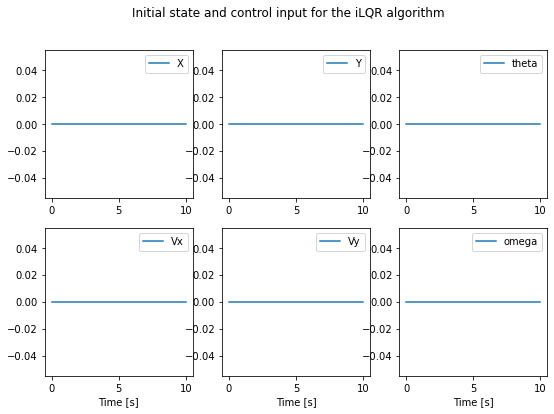

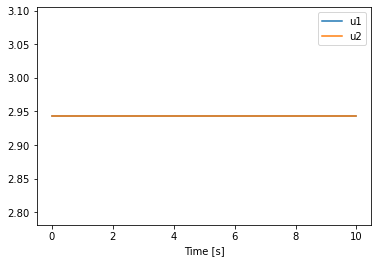

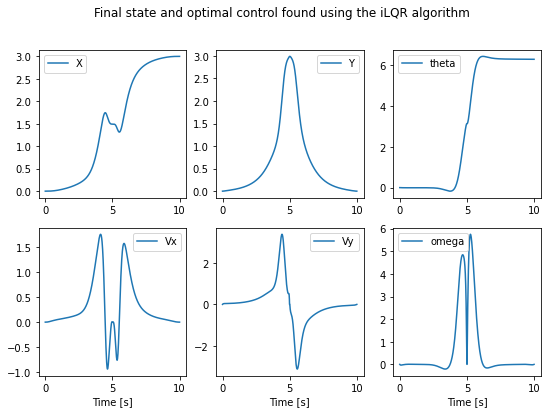

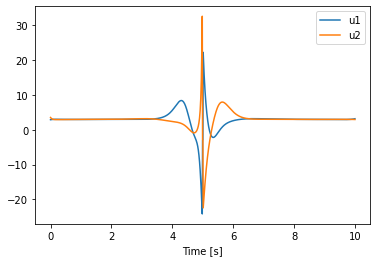

In [5]:
# Drone doing a full flip 

# Function to linearize the dynamics of the drone.
def get_linearlization(z,u):
    A = np.array([[1,quadrotor.DELTA_T,0,0,0,0],[0,1,0,0,-quadrotor.DELTA_T*(u[0]+u[1])*np.cos(z[4])/quadrotor.MASS,0],[0,0,1,quadrotor.DELTA_T,0,0],[0,0,0,1,-quadrotor.DELTA_T*(u[0]+u[1])*np.sin(z[4])/quadrotor.MASS,0],[0,0,0,0,1,quadrotor.DELTA_T],[0,0,0,0,0,1]])
    B = np.array([[0,0],[-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS,-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS,quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA,-quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA]])
    return A,B

# Function which creates state and control costs to promote flipped orientation at t=5 and stabilizes drone at t=10
def cost_function(horizon_length):
    list_of_Q = []
    list_of_R = []
    
    z_target1 = np.array((1.5,0,3,0,np.pi,0)) 
    z_target2 = np.array((3,0,0,0,2*np.pi,0))
    t_lower_target = 0.499
    t_upper_target = 0.501
    
    
    R_tune = 0.1
    
    Q_temp = np.identity(quadrotor.NUMBER_STATES)
    Q1 = 10*Q_temp
    Q2 = 100000*Q_temp
    Q3 = 1*Q_temp
    Q3[4,4] = 10
    Q_end = 100000*Q_temp
    R_temp = R_tune*np.identity(quadrotor.NUMBER_CONTROLS)
    
    for i in range(horizon_length):
        
        if((i<t_lower_target*horizon_length)):
            Q_now = Q1
            
        elif ((i>=t_lower_target*horizon_length)and(i<=t_upper_target*horizon_length)):
            Q_now = Q2    
        else:
            Q_now = Q3
               
        list_of_Q.append(Q_now)
        list_of_R.append(R_temp)
    
    list_of_Q.append(Q_end)
    return list_of_Q,list_of_R,z_target1,z_target2,t_lower_target,t_upper_target


# Function to compute total cost of current trajectory
def compute_cost(z,u,horizon_length):
    total_cost = 0.

    Qn,Rn, z_target1,z_target2, t_lower_target, t_upper_target = cost_function(horizon_length)
    QN = Qn[horizon_length]
    
    for n in range(horizon_length): 
        if(n<t_lower_target*horizon_length):
            total_cost = total_cost + np.transpose(z[:,n])@Qn[n]@(z[:,n]) + np.transpose(u[:,n])@Rn[n]@(u[:,n])
            
        elif ((n>=t_lower_target*horizon_length) and (n<=t_upper_target*horizon_length)):
            total_cost = total_cost + np.transpose(z[:,n]-z_target1)@Qn[n]@(z[:,n]-z_target1) + np.transpose(u[:,n])@Rn[n]@(u[:,n])

        else:
            total_cost = total_cost + np.transpose(z[:,n]-z_target2)@Qn[n]@(z[:,n]-z_target2) + np.transpose(u[:,n])@Rn[n]@(u[:,n])
    #print("total cost = ",total_cost[0])    
    total_cost = total_cost + np.transpose(z[:,horizon_length]-z_target2)@QN@(z[:,horizon_length]-z_target2)
                                                                                  
    #print("total cost = ",total_cost)
    return total_cost

#Function to return hessian and gradients of cost (Quadratic approximation of the cost)
def get_quadratic_approximation_cost(z, u, horizon_length):
    
    Qn_orig, Rn_orig, z_target1,z_target2, t_lower_target, t_upper_target = cost_function(horizon_length)
    
    QN_orig = Qn_orig[horizon_length]
    
    qN = 2*QN_orig@(z[:,horizon_length]-z_target2)
    QN = 2*QN_orig
    
    Qn = []
    Rn = []
    qn = []
    rn = []
    for j in range(horizon_length):
        if((j<t_lower_target*horizon_length)):
            Qn.append(2*Qn_orig[j])
            Rn.append(2*Rn_orig[j])
            qn.append(2*Qn_orig[j]@z[:,j])
            rn.append(2*Rn_orig[j]@(u[:,j])) 
            
        elif((j>=t_lower_target*horizon_length) and (j<=t_upper_target*horizon_length)):
            Qn.append(2*Qn_orig[j])
            Rn.append(2*Rn_orig[j])

            qn.append(2*Qn_orig[j]@(z[:,j]-z_target1))
            rn.append(2*Rn_orig[j]@(u[:,j]))
        
        else:
            Qn.append(2*Qn_orig[j])
            Rn.append(2*Rn_orig[j])
  
            qn.append(2*Qn_orig[j]@(z[:,j]-z_target2))
            rn.append(2*Rn_orig[j]@(u[:,j]))
    
    Qn.append(QN)
    qn.append(qN)
    return Qn,Rn,qn,rn

# Solve LQR equations for current trajectory
def solve_Riccati_recursion(Q, R,q,r,z_traj, u_traj, N):

    
    k=N-1
    K_gains = []
    k_feedforward = []
    
    P_prev=Q[N]
    p_prev=q[N]
    
    while(k>=0):
        
        A,B = get_linearlization(z_traj[:,k],u_traj[:,k])
        
        Kn = -np.linalg.inv(B.transpose()@P_prev@B+R[k])@B.transpose()@P_prev@A
        
        Pn = Q[k]+A.transpose()@P_prev@A + A.transpose()@P_prev@B@Kn
        
        kn = -np.linalg.inv(B.transpose()@P_prev@B+R[k])@(B.transpose()@p_prev+r[k])
        
        pn = q[k]+A.transpose()@p_prev + A.transpose()@P_prev@B@kn
        
        K_gains.append(Kn)
        k_feedforward.append(kn)
        
        P_prev = Pn
        p_prev = pn
        
        k=k-1
        
    
    K_gains.reverse()
    k_feedforward.reverse()
    
    return K_gains, k_feedforward

def integrate_dynamics(z0,u_guess,horizon_length):
    
    z_guess=np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
    z_guess[:,0] = z0
    for i1 in range(horizon_length):
        z_guess[:,i1+1] = quadrotor.get_next_state(z_guess[:,i1], u_guess[:,i1])
    return z_guess

# Integrate dynamics
def forward_dynamics(z0,K_g,k_g,horizon_length,alpha):
    
    z=np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
    z[:,0] = z0
    for i2 in range(horizon_length):
        u[:,i2] = u[:,i2] + K_gains_curr[i2]@(z_curr[:,i2]-z_guess[:,i2])+k_feedforward_curr[i2]
        z[:,i2+1] = quadrotor.get_next_state(z[:,i2], u[:,i2])
    return z_guess, u_guess

# iLQR algorithm implementation
def solve_iLQR(threshold = 0.0001):
    
    
    #initial guess
    
    T = 10 #seconds
    horizon_length = int(T/quadrotor.DELTA_T)
    
    # Initial guess u =mg/2
    u_guess = np.stack((np.repeat([quadrotor.MASS*quadrotor.GRAVITY/2],horizon_length),np.repeat([quadrotor.MASS*quadrotor.GRAVITY/2],horizon_length)))

    #integrate the system to find z_guess
    z0 = np.zeros([quadrotor.NUMBER_STATES])
    
    z_guess = integrate_dynamics(z0,u_guess,horizon_length)
    
    # Save initial guess
    u_initial = u_guess
    z_initial = z_guess
    
    # Initialize prev cost and current cost
    J_prev = compute_cost(z_guess,u_guess,horizon_length)
    thresh_last =1000
    
    while(thresh_last > threshold):
        
        #Backward pass, each return value is a list
        Qn_curr,Rn_curr,qn_curr,rn_curr = get_quadratic_approximation_cost(z_guess, u_guess, horizon_length)
        
        # Linearize at z_guess[t] and u_guess[t]
        K_gains_curr, k_feedforward_curr = solve_Riccati_recursion(Qn_curr,Rn_curr,qn_curr,rn_curr,z_guess, u_guess, horizon_length)

        #Forward pass
        
        #Initialize cost and trajectories
        z_curr = np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
        u_curr = np.empty([quadrotor.NUMBER_CONTROLS, horizon_length])
        z_curr[:,0] = np.zeros([quadrotor.NUMBER_STATES])
        
        for o in range(horizon_length):
            u_curr[:,o] = u_guess[:,o] + K_gains_curr[o]@(z_curr[:,o]-z_guess[:,o])+k_feedforward_curr[o]

            z_curr[:,o+1] = quadrotor.get_next_state(z_curr[:,o],u_curr[:,o])
        
        J_curr = compute_cost(z_curr,u_curr,horizon_length)

        # We now have new states z_curr
        #line search
        if(J_curr>=J_prev):
            alpha = 1
            while(J_curr>=J_prev and alpha>0.01):
                
                z_line = np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
                u_line = np.empty([quadrotor.NUMBER_CONTROLS, horizon_length])
                
                z_line[:,0] = np.zeros([quadrotor.NUMBER_STATES])
                
                for l in range(horizon_length):
                    u_line[:,l] = u_guess[:,l] + K_gains_curr[l]@(z_line[:,l]-z_guess[:,l])+alpha*k_feedforward_curr[l]
                    z_line[:,l+1] = quadrotor.get_next_state(z_line[:,l],u_line[:,l])
                
                J_curr = compute_cost(z_line,u_line,horizon_length)
                if(J_curr<J_prev):
                    # Better trajectory found
                    z_guess = z_line
                    u_guess = u_line
                    thresh_last = J_prev - J_curr
                    J_prev = J_curr
                    break
                else:    
                    # Re-do line search
                    alpha = alpha/2
        else:
            z_guess = z_curr
            u_guess = u_curr
            thresh_last = J_prev - J_curr
            J_prev = J_curr

    return z_initial,u_initial,z_guess, u_guess

z_i,u_i,z_f,u_f=solve_iLQR()
T =10
horizon_length = int(T/quadrotor.DELTA_T)
time = np.arange(0.,(T+quadrotor.DELTA_T), quadrotor.DELTA_T)

# Initial trajectory

t, state_list, u = time, z_i, u_i
# we can plot the results
plt.figure(figsize=[9,6])
plt.suptitle("Initial state and control input for the iLQR algorithm")

plt.subplot(2,3,1)
plt.plot(t, state_list[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_list[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_list[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_list[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_list[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_list[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# Final trajectories

t, state_list, u = time, z_f, u_f
# we can plot the results
plt.figure(figsize=[9,6])
plt.suptitle("Final state and optimal control found using the iLQR algorithm")

plt.subplot(2,3,1)
plt.plot(t, state_list[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_list[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_list[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_list[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_list[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_list[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# Animation

quadrotor.animate_robot(z_f,u_f)